<a href="https://colab.research.google.com/github/Loga19818eeanvesh/CNN_Models/blob/main/1_ResNet.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:

!pip install tensorflow==2.2.0

     |████████████████████████████████| 516.2 MB 3.9 kB/s 
     |████████████████████████████████| 454 kB 48.1 MB/s 
     |████████████████████████████████| 2.9 MB 46.2 MB/s 
     |████████████████████████████████| 3.0 MB 44.6 MB/s 
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.8.0
    Uninstalling tensorflow-estimator-2.8.0:
      Successfully uninstalled tensorflow-estimator-2.8.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.8.0
    Uninstalling tensorboard-2.8.0:
      Successfully uninstalled tensorboard-2.8.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.1.0
    Uninstalling h5py-3.1.0:
      Successfully uninstalled h5py-3.1.0
  Attempting uninstall: gast
    Found existing installation: gast 0.5.3
    Uninstalling gast-0.5.3:
      Successfully uninstalled gast-0.5.3
  Attempting uninstall: tensorflow
    Found existing installation: tensorflow 2.8.0
    Uninstalli

In [1]:
import tensorflow as tf 
print(tf.__version__)

2.2.0


In [2]:
from tensorflow.keras import Model
from tensorflow.keras.layers import Conv2D,BatchNormalization,ReLU,BatchNormalization,MaxPool2D,GlobalAveragePooling2D,Dense


In [43]:
class ResidualBlock(Model):
  def __init__(self,kernel_size,noof_filters,input_depth,stride=(1,1)):
    super(ResidualBlock,self).__init__(name="")
    self.conv1 = Conv2D(filters=noof_filters,kernel_size=kernel_size,strides=stride,padding="same")
    self.conv2 = Conv2D(filters=noof_filters,kernel_size=kernel_size,strides=stride,padding="same")
    self.relu = ReLU()
    self.BatchNorm1 = BatchNormalization()
    self.BatchNorm2 = BatchNormalization()
    self.skip = 1
    if input_depth!=noof_filters:
      self.conv3 = Conv2D(filters=noof_filters,kernel_size=1)
      self.skip=0

  def __call__(self,inputs):
    x = self.conv1(inputs);
    x = self.BatchNorm1(x)
    x = self.relu(x)
    x = self.conv2(x)
    x = self.BatchNorm2(x)
    if(self.skip==0):
      inputs = self.conv3(inputs)
    x = self.relu(inputs+x)
    return x

In [44]:
class ResNetBlock(Model):
  def __init__(self,kernel_size,noof_filters,input_depth,noof_blocks,stride=(1,1)):
    super(ResNetBlock,self).__init__(name="")
    self.noof_blocks = noof_blocks
    ResidualBlocks = {}
    ResidualBlocks["ResidualBlock0"] = ResidualBlock(kernel_size=kernel_size,noof_filters=noof_filters,input_depth=input_depth,stride=stride)
    for i in range(noof_blocks):
      if i==0 :
        continue
      ResidualBlocks["ResidualBlock"+str(i)] = ResidualBlock(kernel_size=kernel_size,noof_filters=noof_filters,input_depth=noof_filters,stride=stride)
    self.Blocks = ResidualBlocks

  def __call__(self,inputs):
    x = self.Blocks["ResidualBlock0"](inputs)
    for i in range(self.noof_blocks):
      if i==0:
        continue
      x = self.Blocks["ResidualBlock"+str(i)](x)

    return x


In [45]:
class ResNet(Model):
  def __init__(self,input_shape,input_filters,kernel_shape,outputs,input_kernel_shape):
    super(ResNet,self).__init__(name="")
    self.conv1 = Conv2D(input_shape=input_shape,filters=input_filters,kernel_size=input_kernel_shape)
    self.BatchNorm = BatchNormalization()
    self.maxpool = MaxPool2D()
    self.relu = ReLU()
    self.ResNetBlock1 = ResNetBlock(kernel_size=kernel_shape,noof_filters=64,input_depth=input_filters,noof_blocks=3)
    self.ResNetBlock2 = ResNetBlock(kernel_size=kernel_shape,noof_filters=128,input_depth=64,noof_blocks=4)
    self.ResNetBlock3 = ResNetBlock(kernel_size=kernel_shape,noof_filters=256,input_depth=128,noof_blocks=6)
    self.ResNetBlock4 = ResNetBlock(kernel_size=kernel_shape,noof_filters=512,input_depth=256,noof_blocks=3)
    self.GlobalAvgPool = GlobalAveragePooling2D()
    self.classifier = Dense(units=outputs,activation=tf.keras.activations.softmax)

  def __call__(self,inputs,training=False):
    x = self.conv1(inputs)
    x = self.BatchNorm(x)
    x = self.relu(x)
    x = self.maxpool(x)
    x = self.ResNetBlock1(x)
    x = self.ResNetBlock2(x)
    x = self.ResNetBlock3(x)
    x = self.ResNetBlock4(x)
    x = self.GlobalAvgPool(x)
    x = self.classifier(x)
    return x

In [46]:
resnet_34layer_model = ResNet(input_shape=(28,28,1),input_filters=64,kernel_shape=3,outputs=10,input_kernel_shape=7)

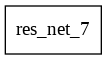

In [47]:
from tensorflow.python.keras.utils.vis_utils import plot_model
plot_model(resnet_34layer_model , to_file = "resnet.png" , show_shapes = True , show_layer_names = True)

In [48]:
resnet_34layer_model.compile(optimizer='adam' , loss = tf.keras.losses.sparse_categorical_crossentropy , metrics=['acc'])

In [54]:
import tensorflow_datasets as tfds

# load dataset
(trainX, trainY), (testX, testY) = mnist.load_data()
# reshape dataset to have a single channel
trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
testX = testX.reshape((testX.shape[0], 28, 28, 1))

def preprocess(f):
    return tf.cast(f['image'] , 'float32') / 255.0  , f["label"]

dataset = tfds.load(name='mnist' , split=tfds.Split.TEST)
dataset = dataset.map(preprocess).batch(32)

In [55]:
history = resnet_34layer_model.fit(dataset , epochs=1)

313/313 [==============================] - 3209s 10s/step - loss: 2.3030 - acc: 0.1136


In [ ]:
resnet_34layer_model.summary()